In [1]:
# Standard library
import os
import gc
import time
import math
import random
import logging
import warnings
logging.basicConfig(level=logging.ERROR)

# Scientific computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Deep learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.parametrizations import weight_norm
from sklearn.metrics import pairwise_distances

# Computer vision
import cv2
import torchvision
from PIL import Image
from torchvision import transforms

# Miscellaneous utilities
from tqdm import tqdm
import timm
import einops
from einops import rearrange
from sklearn.model_selection import KFold
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
import kagglehub

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42

In [3]:
path = kagglehub.dataset_download("khanhpt1999/data-1")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/data-1


# **Model**

In [4]:
img = Image.open("/kaggle/input/test-images/image_2025-05-05_142003010.png").convert("RGB")
print("PIL image size:", img.size, "mode:", img.mode)

transform = transforms.Compose([
    transforms.Resize((64, 64)),        
    #transforms.CenterCrop(224),           
    transforms.ToTensor(),                
    transforms.Normalize( 
        mean=[0.5,0.5,0.5],
        std=[0.5,0.5,0.5]
    ),
])

inpt: torch.Tensor = transform(img)
print("Tensor shape:", inpt.shape, "dtype:", inpt.dtype, "range:", inpt.min(),"→",inpt.max())

PIL image size: (1080, 608) mode: RGB
Tensor shape: torch.Size([3, 64, 64]) dtype: torch.float32 range: tensor(-0.9922) → tensor(0.9922)


In [5]:
inpt = inpt.unsqueeze(0)
print(f"Shape of Input: {inpt.shape}")

Shape of Input: torch.Size([1, 3, 64, 64])


In [6]:
import torch
import torch.nn as nn
import math

class ElectricForceModel(nn.Module):

    def __init__(
        self,
        imsize = 64,
        epsilon=1,
        v0 = 0,
        layers = 3,
        loops = 4,
        debug = False,
        mass = 1,
        time = 1,
    ):
        super().__init__()

        self.register_buffer('v0', torch.tensor([v0], dtype=torch.float32))
        self.register_buffer('epsilon', torch.tensor([epsilon], dtype=torch.float32))
        self.register_buffer('time', torch.tensor([time], dtype=torch.float32))
        self.register_buffer('mass', torch.tensor([mass], dtype=torch.float32))
        
        self.imsize = imsize
        self.layers = layers
        self.loops = loops
        self.debug = debug

        self.mapping_to_vector_space = nn.Conv2d(3, 2, 1, 1, 0)
        self.space_norm = nn.Tanh()
        self.mapping_to_ipt = nn.Conv2d(2, 3, 1, 1, 0)

    def compute_distance(self, ipt):
        if self.debug:
            print(f"Running compute_distance...")
            print(f" ")
            print(f"ipt Shape: {ipt.shape}") # [B, 3, self.imsize, self.imsize]
        
        zeta = self.mapping_to_vector_space(ipt) # [B, 2, self.imsize, self.imsize]
        zeta = self.space_norm(zeta) # [B, 2, self.imsize, self.imsize]
        if self.debug:
            print(f"zeta Shape: {zeta.shape}")

        B, C, H, W = zeta.shape
        N = H*W

        pts = zeta.view(B, 2, N) # [B, 2, N]
        if self.debug:
            print(f"pts Shape: {pts.shape}")

        x, y = pts[:, 0], pts[:, 1] # [B, N], [B, N]
        if self.debug:
            print(f"x Shape: {x.shape}")
            print(f"y Shape: {y.shape}")

        zflat = pts.permute(0, 2, 1) # [B, N, 2]
        if self.debug:
            print(f"zflat Shape: {zflat.shape}")

        D = torch.cdist(zflat, zflat, p=2)
        D = torch.where(D==0, float('inf'), D) # [B, N, N]
        if self.debug:
            print(f"D Shape: {D.shape}")

        inverse_sq_dist = D.pow(-2) # [B, N, N]
        if self.debug:
            print(f"inverse_sq_dist Shape: {inverse_sq_dist.shape}")
            
        if self.debug:
            print("-"*59)
        
        return zeta, x, y, inverse_sq_dist

    def compute_angle(self, x, y):
        theta_rad = torch.atan2( # [B, N, N]
            y.unsqueeze(2) - y.unsqueeze(1), # [B, N, 1] - [B, 1, N]
            x.unsqueeze(2) - x.unsqueeze(1), # [B, N, 1] - [B, 1, N]
        )
        theta_deg = theta_rad * (180.0 / math.pi) # [B, N, N]
        if self.debug:
            print(f"Running compute_angle...")
            print(f" ")
            print(f"theta_rad Shape: {theta_rad.shape}")
            print(f"theta_deg Shape: {theta_deg.shape}")
            
        if self.debug:
            print("-"*59)
        return theta_deg, theta_rad

    def compute_electric_force(self, ipt, theta_rad, inverse_sq_dist):
        k_E = 1.0 / (4.0 * math.pi * self.epsilon)
        
        B, C, H, W = ipt.shape
        N = H*W
        
        ipt_reshaped = ipt.view(B, N, C) # [B, N, C]
        
        qi_qj = ipt_reshaped.unsqueeze(2) * ipt_reshaped.unsqueeze(1) # [B, N, 1, C] * [B, 1, N, C] -> [B, N, N, C]
        qi_qj = torch.mean(qi_qj, dim = 3) # [B, N, N]
        if self.debug:
            print(f"Running compute_electric_force...")
            print(" ")
            print(f"qi_qj Shape: {qi_qj.shape}")

        Fx = k_E * qi_qj * inverse_sq_dist * torch.cos(theta_rad) # [B, N, N]
        Fy = k_E * qi_qj * inverse_sq_dist * torch.sin(theta_rad) # [B, N, N]

        Fx = torch.sum(Fx, dim = 2) # [B, N]
        Fy = torch.sum(Fy, dim = 2) # [B, N]
        
        if self.debug:
            print(f"Fx Shape: {Fx.shape}")
            print(f"Fy Shape: {Fy.shape}")
            print("-"*59)
            
        return Fx, Fy

    def compute_vector_translation(self, Fx, Fy, zeta):
        if self.debug:
            print(f"Starting compute_vector_translation...")
            print(" ")
            
        ax = Fx / self.mass # [B, N]
        ay = Fy / self.mass # [B, N]
        if self.debug:
            print(f"ax Shape: {ax.shape}")
            print(f"ay Shape: {ay.shape}")
            
        B, N = Fx.shape
        v0 = self.v0.expand(B, N) # [B, N]
        
        if self.debug:
            print(f"v0 Shape: {v0.shape}")
            
        vx = v0 + ax * self.time # [B, N]
        vy = v0 + ay * self.time # [B, N]
        vx = vx.reshape(B, self.imsize, self.imsize) # [B, self.imsize, self.imsize]
        vy = vy.reshape(B, self.imsize, self.imsize) # [B, self.imsize, self.imsize]
        if self.debug:
            print(f"vx Shape: {vx.shape}")
            print(f"vy Shape: {vy.shape}")
            
        if self.debug:
            print(f"zeta Shape: {zeta.shape}")
            print(f"zeta[:, 0] Shape: {zeta[:, 0].shape}")
            print(f"zeta[:, 1] Shape: {zeta[:, 1].shape}")
        zeta[:, 0] += vx # [B, 2, self.imsize, self.imsize]
        zeta[:, 1] += vy # [B, 2, self.imsize, self.imsize]

        
        if self.debug:
            print(f"Updated zeta Shape: {zeta.shape}")
            print(f"-"*59)
            
        return zeta

    def update_input(self, ipt, zeta):
        map_to_ipt = self.mapping_to_ipt(zeta) # [B, 3, self.imsize, self.imsize]
        ipt = map_to_ipt*0.5 + ipt*0.5
        return ipt
            
    def forward(self, ipt):
        assert ipt.shape[2] and ipt.shape[3] == self.imsize, "Input Shape's Height and Width must match parameter imsize"
        for layer in range(self.layers):
            if self.debug:
                print(f"Running Layer {layer + 1}/{self.layers}")
                print(f"-"*59)
            for loop in range(self.loops):
                print(f"Starting {loop + 1}/{self.loops} for compute_electric_force...")
                zeta, x, y, inverse_sq_dist = self.compute_distance(ipt)
                theta_deg, theta_rad = self.compute_angle(x, y)
                Fx, Fy = self.compute_electric_force(ipt, theta_rad, inverse_sq_dist)
                zeta = self.compute_vector_translation(Fx, Fy, zeta)
  
            zeta = self.space_norm(zeta)
            ipt = self.update_input(ipt, zeta)
        
        return ipt, zeta

In [7]:
model = ElectricForceModel(debug = True)
model = model.to(device)

out, zeta = model(inpt.to(device))

Running Layer 1/3
-----------------------------------------------------------
Starting 1/4 for compute_electric_force...
Running compute_distance...
 
ipt Shape: torch.Size([1, 3, 64, 64])
zeta Shape: torch.Size([1, 2, 64, 64])
pts Shape: torch.Size([1, 2, 4096])
x Shape: torch.Size([1, 4096])
y Shape: torch.Size([1, 4096])
zflat Shape: torch.Size([1, 4096, 2])
D Shape: torch.Size([1, 4096, 4096])
inverse_sq_dist Shape: torch.Size([1, 4096, 4096])
-----------------------------------------------------------
Running compute_angle...
 
theta_rad Shape: torch.Size([1, 4096, 4096])
theta_deg Shape: torch.Size([1, 4096, 4096])
-----------------------------------------------------------
Running compute_electric_force...
 
qi_qj Shape: torch.Size([1, 4096, 4096])
Fx Shape: torch.Size([1, 4096])
Fy Shape: torch.Size([1, 4096])
-----------------------------------------------------------
Starting compute_vector_translation...
 
ax Shape: torch.Size([1, 4096])
ay Shape: torch.Size([1, 4096])
v0 Sh

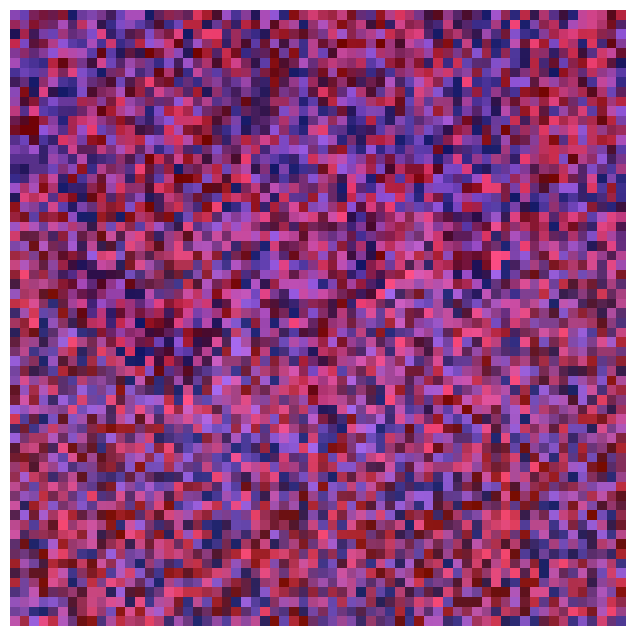

In [8]:
def show_tensor_as_image(tensor):
    # Move to CPU and detach from computational graph
    tensor = tensor.detach().cpu()
    
    # Handle different tensor shapes
    if tensor.dim() == 4:  # [B, C, H, W]
        tensor = tensor[0]  # Take first batch
    
    if tensor.dim() == 3:  # [C, H, W]
        if tensor.shape[0] == 1:  # Grayscale [1, H, W]
            tensor = tensor.squeeze(0)  # Remove channel dim -> [H, W]
        elif tensor.shape[0] == 3:  # RGB [3, H, W]
            tensor = tensor.permute(1, 2, 0)  # -> [H, W, 3]
    
    img = tensor.numpy()
    
    if img.max() > 1.0 or img.min() < 0.0:
        img = (img - img.min()) / (img.max() - img.min())
    
    # Display
    plt.figure(figsize=(8, 8))
    if len(img.shape) == 2:  # Grayscale
        plt.imshow(img, cmap='gray')
    else:  # RGB
        plt.imshow(img)
    plt.axis('off')
    plt.show()

show_tensor_as_image(out)